Setup & Imports

In [44]:
import os
from platform import architecture

import torch
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision.models import efficientnet_b0
from torch.utils.data import Dataset, DataLoader, random_split
import json
from torchvision.datasets.folder import default_loader
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from torchvision import datasets

#displays plots inline
%matplotlib inline

Configuration & Device

In [140]:
PROJECT_ROOT = os.getcwd()
# Modes: 'produce' fruit type or 'variation' variation
MODE = 'produce'
FRUIT = 'Raspberry'         # only applied when MODE = 'variation'

#path directorys
data_dir = os.path.join(PROJECT_ROOT, 'data')
checkpoint_dir = os.path.join(PROJECT_ROOT, 'checkpoints')
saves_dir = os.path.join(PROJECT_ROOT, 'saves')

# if statement for model selection 
if MODE == 'produce':
    MODEL_NAME = 'resnet50'
    NUM_CLASSES = 4 #4 if training all 4 fruits, but 2 if only doing 2 fruits
    FRUIT = '' #for file naming purposes when saving .pt
    data_path = data_dir
elif MODE == 'variation':
    MODEL_NAME = 'efficientnet_b0'
    NUM_CLASSES = 3
    data_path = os.path.join(data_dir, FRUIT)  # single fruit folder
else:
    raise ValueError("MODE must be 'produce' or 'variation'")

print(f"[Config] Mode: {MODE}, Model: {MODEL_NAME}, Classes: {NUM_CLASSES}")
print(f"[Config] Data Path: {data_path}")

#Hyperparameters
BATCH_SIZE = 32
EPOCHS     = 5
LR         = 1e-6
VAL_SPLIT  = 0.2

#Device selection, basically runs macbook specific before cuda then cpu
DEVICE = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"[Config] Device: {DEVICE}")


[Config] Mode: produce, Model: resnet50, Classes: 4
[Config] Data Path: /Users/durrrek/PycharmProjects/CV Image Classifer/data
[Config] Device: mps


Dataloader

In [121]:


def get_dataloaders(root_dir, val_split=0.2, batch_size=32):

# augmentations for fine tuning
    train_tfm = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224, scale=(0.8,1.2)),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.ToTensor(),
])

    '''
    #baseline training
    train_tfm = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])
    '''
    val_tfm = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
    ])

    # data directory was setup in a way where Imagefolder would be able to run without modification
    full_ds = datasets.ImageFolder(root=root_dir, transform=train_tfm)

    total   = len(full_ds)
    val_n   = int(total * val_split)
    train_n = total - val_n
    train_ds, val_ds = random_split(full_ds, [train_n, val_n])
    #print(full_ds.classes)      # should print ['Apple','Grapes']
    #print(full_ds.class_to_idx) # should map Apple→0, Grapes→1
    # swap in the val transforms
    val_ds.dataset.transform = val_tfm

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=0, pin_memory=True)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

    return train_loader, val_loader, full_ds.classes



Train Model Function

In [108]:
def train_model(model, train_loader, val_loader, class_names, criterion, optimizer, epochs, device):
    #trains model and saves the metrics as checkpoints after each epoch. Handles interrupts by saving current state, results haven't improved so removed the code for continuation from interrupted epochs.

    model.to(device)
    metrics = []
    for epoch in range(epochs):
        try:
            # training
            model.train()
            correct, total = 0, 0
            for x, y in train_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)
                optimizer.zero_grad(); loss.backward(); optimizer.step()
                preds = out.argmax(1)
                correct += (preds == y).sum().item(); total += y.size(0)
            train_acc = correct / total

            #Validation
            model.eval()
            vcorrect, vtotal, y_true, y_pred = 0, 0, [], []
            with torch.no_grad():
                for x, y in val_loader:
                    x = x.to(device)
                    out = model(x)
                    preds = out.argmax(1).cpu()
                    vcorrect += (preds == y).sum().item(); vtotal += y.size(0)
                    y_true.extend(y.numpy()); y_pred.extend(preds.numpy())
            val_acc = vcorrect / vtotal
            metrics.append({'epoch': epoch+1, 'train_acc': train_acc, 'val_acc': val_acc})

            print(f"Epoch {epoch+1}/{epochs} - Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

            # saves checkpoint after each epoch
            ckpt_path = os.path.join(checkpoint_dir, f"{MODEL_NAME}_{MODE}_epoch{epoch+1}_{FRUIT}.pt")
            torch.save(model.state_dict(), ckpt_path)
            print(f"[Saved] checkpoint for epoch {epoch+1}: {ckpt_path}")
            #metrics
            metrics_path = os.path.join(checkpoint_dir, f"{MODEL_NAME}_{MODE}_metrics_{FRUIT}.json")
            with open(metrics_path, 'w') as f:
                json.dump(metrics, f)

        except KeyboardInterrupt:
            #Save on interruption
            print(f"[Interrupted] at epoch {epoch+1}. Saving current state and metrics.")
            ckpt_path = os.path.join(checkpoint_dir, f"{MODEL_NAME}_{MODE}_epoch{epoch+1}_interrupted_{FRUIT}.pt")
            torch.save(model.state_dict(), ckpt_path)
            metrics_path = os.path.join(checkpoint_dir, f"{MODEL_NAME}_{MODE}_metrics.json")
            with open(metrics_path, 'w') as f:
                json.dump(metrics, f)
            raise

1st time Training

In [ ]:

#call dataloaders
train_loader, val_loader, class_names = get_dataloaders(data_path, VAL_SPLIT, BATCH_SIZE)

# initialize the models
if MODE == 'produce':
    model = models.resnet50(weights=True)
    model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
else:
    model = efficientnet_b0(weights=True)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, NUM_CLASSES)

# Save checkpoint
#os.makedirs(checkpoint_dir, exist_ok=True)
#torch.save(model.state_dict(), os.path.join(checkpoint_dir, f"{MODEL_NAME}_{MODE}.pt"))
#print(f"[Saved] Model saved to {checkpoint_dir}")


In [ ]:
#train model

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)
train_model(model, train_loader, val_loader, class_names, criterion, optimizer, EPOCHS, DEVICE)

In [49]:
#for finding best epoch
# there are 2 finding best epoch, one for top, other for bottom (for ease)

with open('checkpoints/efficientnet_b0_variation_metrics_Apple.json') as f: #resnet50_produce_metrics_B1.json        efficientnet_b0_variation_metrics_RaspberryB1.json
    metrics = json.load(f)
best = max(metrics, key=lambda m: m['val_acc'])
print(f"Best on batch → epoch {best['epoch']}: train {best['train_acc']:.4f}, val {best['val_acc']:.4f}")

Best on batch → epoch 5: train 0.9858, val 0.9517


Accuracy FOR produce ONLY

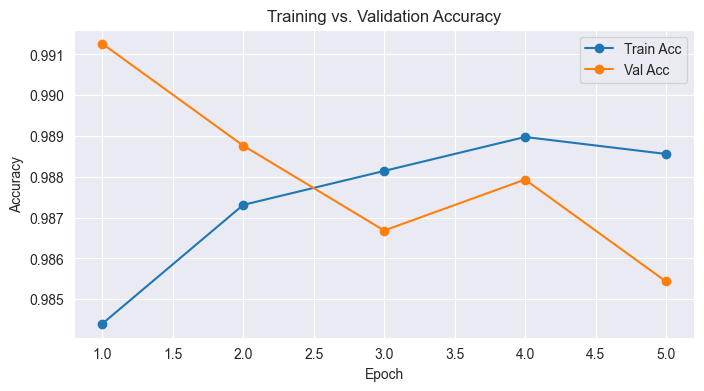

In [56]:

#load in metrics
metrics_path = 'checkpoints/resnet50_produce_metrics_.json'
with open(metrics_path) as f:
    metrics = json.load(f)

# assigning vals
epochs     = [m['epoch']     for m in metrics]
train_accs = [m['train_acc'] for m in metrics]
val_accs   = [m['val_acc']   for m in metrics]

# plotting
plt.figure(figsize=(8,4))
plt.plot(epochs, train_accs, marker='o', label='Train Acc')
plt.plot(epochs, val_accs,   marker='o', label='Val Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.savefig(os.path.join(checkpoint_dir, f"{MODEL_NAME}_accuracy_plot.png"), dpi=150, bbox_inches='tight')
plt.legend(); plt.grid(True)
plt.show()

Confusion Matrix

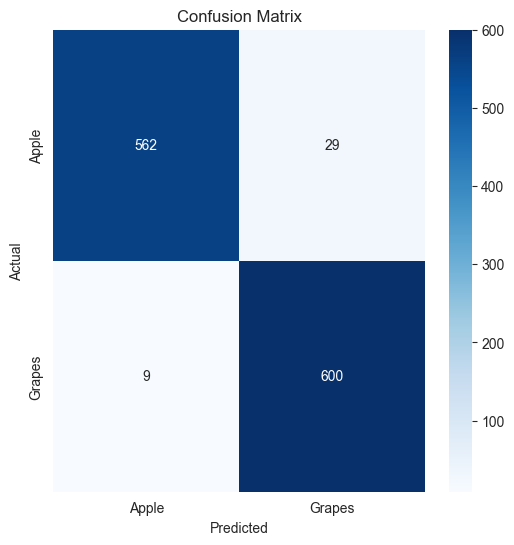

In [137]:
# recompute confusion matrix on validation set
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for x, y in val_loader:
        x = x.to(DEVICE)
        outputs = model(x)
        preds = outputs.argmax(dim=1).cpu().tolist()
        y_pred.extend(preds)
        y_true.extend(y.tolist())

# confusion matrix and plotting
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.savefig(os.path.join(checkpoint_dir, f"{MODEL_NAME}_{FRUIT}confusion_matrix.png"), dpi=150, bbox_inches='tight')
plt.show()

In [136]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred, target_names=class_names)

# print report
print(report)

# save to txt file
out_path = "checkpoints/resnet50_produce_classification_reportApple_Grape.txt" #efficientnet_b0_variation_classification_report_Raspberry  resnet50_produce_classification_report
with open(out_path, 'w') as f:
    f.write(report)

print(f"Saved classification report to {out_path}")

              precision    recall  f1-score   support

       Apple       0.91      0.92      0.91       587
      Grapes       0.92      0.92      0.92       613

    accuracy                           0.92      1200
   macro avg       0.92      0.92      0.92      1200
weighted avg       0.92      0.92      0.92      1200

Saved classification report to checkpoints/resnet50_produce_classification_reportApple_Grape.txt


Accuracy FOR VARIATION ONLY

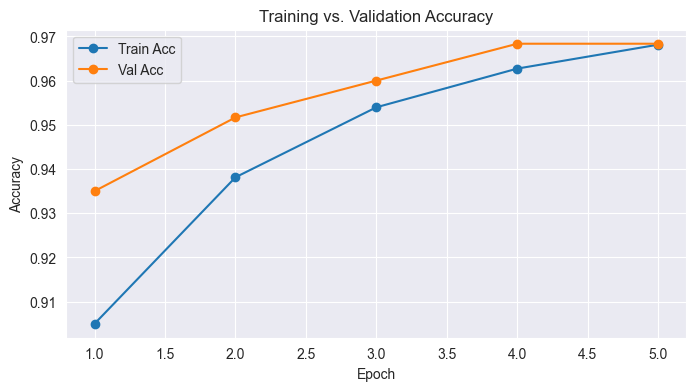

In [135]:

#loading metrics JSON and plot accuracy curves
with open(os.path.join(checkpoint_dir, f"{MODEL_NAME}_{MODE}_metrics_{FRUIT}.json")) as f:
    metrics = json.load(f)
epochs = [m['epoch'] for m in metrics]
train_accs = [m['train_acc'] for m in metrics]
val_accs   = [m['val_acc'] for m in metrics]

plt.figure(figsize=(8,4))
plt.plot(epochs, train_accs, marker='o', label='Train Acc')
plt.plot(epochs, val_accs,   marker='o', label='Val Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.legend(); plt.grid(True)
plt.savefig(os.path.join(checkpoint_dir, f"{MODEL_NAME}_{FRUIT}_accuracy_plot.png"), dpi=150, bbox_inches='tight')
plt.show()

Looking at Weights for produce ONLY

In [63]:
#checking weights and loading it in for fine-tuning
epoch_path = 'saves/resnet50_produce.pt' #change this out to whichever epoch
state = torch.load(epoch_path, map_location='cpu')
model.load_state_dict(state)

model.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

/Users/durrrek/PycharmProjects/CV Image Classifer/.bvenv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [138]:
# unfreeze all layers
for param in model.parameters():
    param.requires_grad = True

Checking for Best Epoch

In [89]:
#2nd checking best epoch
with open('first training/efficientnet_b0_variation_metrics_Raspberry.json') as f: #resnet50_produce_metrics_B1.json        efficientnet_b0_variation_metrics_RaspberryB1.json
    metrics = json.load(f)
best = max(metrics, key=lambda m: m['val_acc'])
print(f"Best on batch → epoch {best['epoch']}: train {best['train_acc']:.4f}, val {best['val_acc']:.4f}")

Best on batch → epoch 8: train 0.9963, val 1.0000


edit: I realized that the method to approach this back then was wrong and stopped updating it

Best Epochs:<br>
produce: <br>
batch1 → epoch 8: train 0.9891, val 0.9750 →→ batch2 → epoch 9: train 0.9963, val 0.9950 <br>
batch2 → epoch 3: train 0.9728, val 0.9738 →→ batch1 → epoch 1: train 0.9835, val 0.9788 <br>
batch3 WIP <br>

Variation: <br>
Apple: <br>
batch1 → epoch 8: train 0.9962, val 0.9400 →→ batch2 → epoch 6: train 0.9938, val 1.0000 <br>
 <br>
batch3 WIP <br>

Grapes: <br>
batch1 → epoch 10: train 0.9988, val 0.9950 →→ batch2 → epoch 3: train 0.9789, val 1.0000 <br>
 <br>
batch3 WIP <br>

Peach: <br>
batch1 → epoch 3: train 0.9789, val 1.0000 →→ batch2 → epoch 1: train 0.9913, val 1.0000 <br>
 <br>
batch3 WIP <br>

Raspberry: <br>
batch1 → epoch 2: train 0.9788, val 1.0000 →→ batch2 → epoch 5: train 0.9975, val 1.0000 <br>
 <br>
batch3 WIP <br>



Rebuilding architecture

In [104]:
if MODE == 'produce':
    model = models.resnet50(weights=True)
    model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
else:
    model = efficientnet_b0(weights=True)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, NUM_CLASSES)

/Users/durrrek/PycharmProjects/CV Image Classifer/.bvenv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Picking best epoch for produce and loading it in

In [105]:


#loading best epoch from pre-training for produce
ckpt_path = f'fineTune1/resnet50_produce_epoch1_.pt'
state = torch.load(ckpt_path, map_location='cpu')
model.load_state_dict(state)
model.eval()


model.to(DEVICE)

RuntimeError: Error(s) in loading state_dict for ResNet:
	size mismatch for fc.weight: copying a param with shape torch.Size([4, 2048]) from checkpoint, the shape in current model is torch.Size([2, 2048]).
	size mismatch for fc.bias: copying a param with shape torch.Size([4]) from checkpoint, the shape in current model is torch.Size([2]).

Picking best epoch for VARIATION and loading it in

In [91]:


#loading best epoch from pre-training for variation
ckpt_path = f'first training/efficientnet_b0_variation_epoch8_Raspberry.pt'
state = torch.load(ckpt_path, map_location='cpu')
model.load_state_dict(state)
model.eval()

model.to(DEVICE)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

Training on 2nd Batch

In [133]:
train_loader, val_loader, class_names = get_dataloaders(data_path, VAL_SPLIT, BATCH_SIZE)

In [134]:

#redefining before training model
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)
train_model(model, train_loader, val_loader, class_names, criterion, optimizer, EPOCHS, DEVICE)


Epoch 1/5 - Train Acc: 0.9050, Val Acc: 0.9350
[Saved] checkpoint for epoch 1: /Users/durrrek/PycharmProjects/CV Image Classifer/checkpoints/resnet50_produce_epoch1_.pt
Epoch 2/5 - Train Acc: 0.9381, Val Acc: 0.9517
[Saved] checkpoint for epoch 2: /Users/durrrek/PycharmProjects/CV Image Classifer/checkpoints/resnet50_produce_epoch2_.pt
Epoch 3/5 - Train Acc: 0.9540, Val Acc: 0.9600
[Saved] checkpoint for epoch 3: /Users/durrrek/PycharmProjects/CV Image Classifer/checkpoints/resnet50_produce_epoch3_.pt
Epoch 4/5 - Train Acc: 0.9627, Val Acc: 0.9683
[Saved] checkpoint for epoch 4: /Users/durrrek/PycharmProjects/CV Image Classifer/checkpoints/resnet50_produce_epoch4_.pt
Epoch 5/5 - Train Acc: 0.9681, Val Acc: 0.9683
[Saved] checkpoint for epoch 5: /Users/durrrek/PycharmProjects/CV Image Classifer/checkpoints/resnet50_produce_epoch5_.pt


Best model

In [98]:
with open('checkpoints/efficientnet_b0_variation_metrics_Peach.json') as f: #resnet50_produce_metrics_B1.json        efficientnet_b0_variation_metrics_RaspberryB1.json
    metrics = json.load(f)
best = max(metrics, key=lambda m: m['val_acc'])
print(f"Best on batch → epoch {best['epoch']}: train {best['train_acc']:.4f}, val {best['val_acc']:.4f}")

Best on batch → epoch 1: train 0.9963, val 1.0000


In [8]:
import os

#making sure directory exists
os.makedirs('web_app/models', exist_ok=True)

#exporting
torch.onnx.export(
    produce_model,
    dummy,
    'web_app/models/produce.onnx',
    input_names=['input'],
    output_names=['output'],
    opset_version=12,
    dynamic_axes={ 'input':{0:'batch'}, 'output':{0:'batch'} }
)

Exporting models to omnx

Produce model

In [141]:
import torch
from torchvision import models
from torchvision.models import efficientnet_b0

produce_ckpt = 'checkpoints/resnet50_produce_epoch5_.pt'   # best epoch
produce_model = models.resnet50(weights=True)
produce_model.fc = torch.nn.Linear(produce_model.fc.in_features, 4)
produce_model.load_state_dict(torch.load(produce_ckpt, map_location='cpu'))
produce_model.eval()

dummy = torch.randn(1,3,224,224)
torch.onnx.export(
    produce_model, dummy,
    'web_app/models/produce.onnx',
    input_names=['input'],
    output_names=['output'],
    opset_version=12,
    dynamic_axes={ 'input':{0:'batch'}, 'output':{0:'batch'} }
)

RuntimeError: Error(s) in loading state_dict for ResNet:
	size mismatch for fc.weight: copying a param with shape torch.Size([2, 2048]) from checkpoint, the shape in current model is torch.Size([4, 2048]).
	size mismatch for fc.bias: copying a param with shape torch.Size([2]) from checkpoint, the shape in current model is torch.Size([4]).

Variation model

In [99]:
variation_paths = {
    'Apple':     'checkpoints/efficientnet_b0_variation_epoch1_Apple.pt',
    'Grapes':    'checkpoints/efficientnet_b0_variation_epoch1_Grapes.pt',
    'Peach':     'checkpoints/efficientnet_b0_variation_epoch1_Peach.pt',
    'Raspberry': 'checkpoints/efficientnet_b0_variation_epoch1_Raspberry.pt',
}

for fruit, ckpt in variation_paths.items():
    vm = efficientnet_b0(weights=True)
    vm.classifier[1] = torch.nn.Linear(vm.classifier[1].in_features, 3)
    vm.load_state_dict(torch.load(ckpt, map_location='cpu'))
    vm.eval()
    torch.onnx.export(
        vm, dummy,
        f'web_app/models/variation_{fruit}.onnx',
        input_names=['input'],
        output_names=['output'],
        opset_version=12,
        dynamic_axes={ 'input':{0:'batch'}, 'output':{0:'batch'} }
    )

/Users/durrrek/PycharmProjects/CV Image Classifer/.bvenv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
